In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import os 
import plotly.graph_objs as go 
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
!pip install surprise
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193659 sha256=f9fde81dd7d2998d2aa5ca19483c9023b69b31c6f912aec83ba5686c8944ee44
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Exploración**

In [4]:
os.getcwd()
os.chdir('/content/drive/MyDrive/Analítica 3 para dummies ')

In [5]:
conn=sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies')
cur = conn.cursor()

In [6]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('ratings',), ('movies',), ('usuarios',), ('usuarios_sel',), ('movies_sel',), ('movies_final',), ('ratings_final',), ('full_ratings',), ('df_final2',), ('df_final',), ('reco',)]


In [7]:
movies = pd.read_sql('select * from movies', conn)
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [8]:
ratings = pd.read_sql('select * from ratings', conn)
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [9]:
movies.info()
movies.duplicated().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


0

In [10]:
ratings.info()
ratings.duplicated().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


0

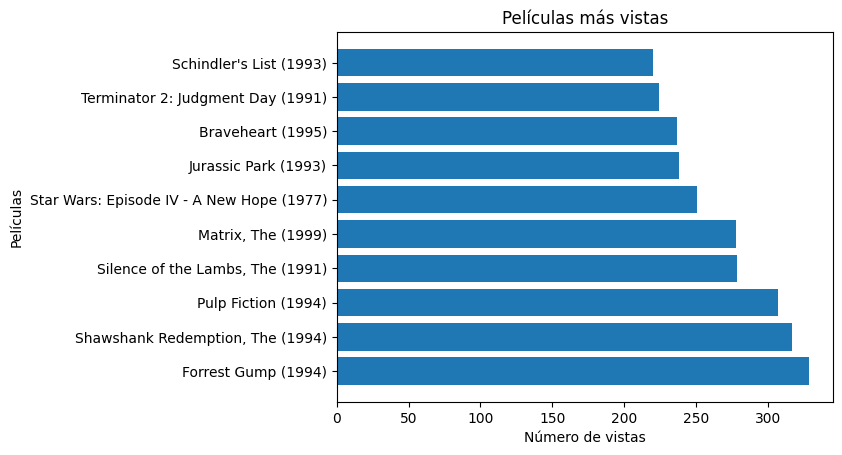

In [11]:
# 10 peliculas mas vistas 
vistas = pd.read_sql(''' Select title as pelicula,
                         count(*) as vistas
                         from movies inner join ratings on
                         movies.movieID = ratings.movieId
                         group by title
                         order by vistas desc limit 10
                         ''',conn )

plt.barh(vistas['pelicula'], vistas['vistas'])
plt.xlabel('Número de vistas')
plt.ylabel('Películas')
plt.title('Películas más vistas')
plt.show()

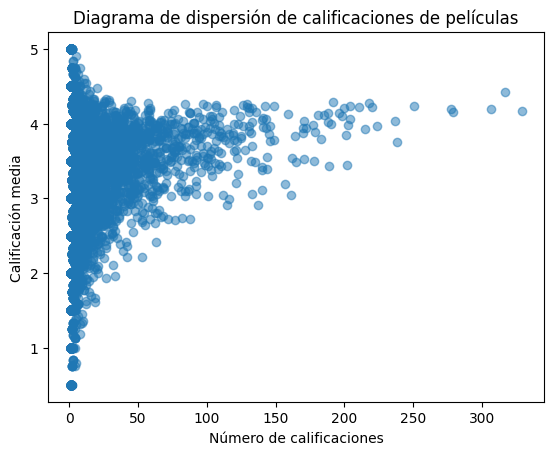

In [12]:
# dispersion de las calificaciones de peliculas 
calificaciones = pd.read_sql('''SELECT title, COUNT(ratings.rating) as num_ratings, AVG(ratings.rating) as avg_rating
                FROM movies
                LEFT JOIN ratings ON movies.movieId = ratings.movieId
                GROUP BY title''',conn)

plt.scatter(calificaciones['num_ratings'], calificaciones['avg_rating'], alpha=0.5)
plt.title('Diagrama de dispersión de calificaciones de películas')
plt.xlabel('Número de calificaciones')
plt.ylabel('Calificación media')
plt.show()


In [13]:
# Peliculas con mas de un genero
pd.read_sql('''SELECT title, genres
                FROM movies
                WHERE LENGTH(genres) - LENGTH(REPLACE(genres, '|', '')) >= 1
                limit 10
                         ''',conn )

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Heat (1995),Action|Crime|Thriller
5,Sabrina (1995),Comedy|Romance
6,Tom and Huck (1995),Adventure|Children
7,GoldenEye (1995),Action|Adventure|Thriller
8,"American President, The (1995)",Comedy|Drama|Romance
9,Dracula: Dead and Loving It (1995),Comedy|Horror


In [14]:
# Peliculas con calificacion de 5 
pd.read_sql('''SELECT title, rating
                From movies inner join ratings on
                Movies.movieID = ratings.movieId
                WHERE rating = 5.0
                         ''',conn )

,title,rating
0,Seven (a.k.a. Se7en) (1995),5.0
1,"Usual Suspects, The (1995)",5.0
2,Bottle Rocket (1996),5.0
3,Rob Roy (1995),5.0
4,Canadian Bacon (1995),5.0
...,...,...
13206,The Nice Guys (2016),5.0
13207,Arrival (2016),5.0
13208,John Wick: Chapter Two (2017),5.0
13209,Get Out (2017),5.0


In [15]:
###calcular la distribución de calificaciones
distribucion = pd.read_sql(""" select 
                                    rating as calificacion, 
                                    count(*) as conteo 
                                    from ratings
                                    group by rating
                                    order by conteo desc""", conn)
distribucion

,calificacion,conteo
0,4.0,26818
1,3.0,20047
2,5.0,13211
3,3.5,13136
4,4.5,8551
5,2.0,7551
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1370


In [16]:
data  = go.Bar( x=distribucion.calificacion,y=distribucion.conteo, text=distribucion.conteo, textposition="outside")
Layout=go.Layout(title="Count of ratings",xaxis={'title':'Rating'},yaxis={'title':'Count'})
go.Figure(data,Layout)

In [17]:
rating_users=pd.read_sql(''' select userId as user_id,
                         count(*) as cnt_rat
                         from ratings
                         group by userId
                         order by cnt_rat asc
                         ''',conn )

In [18]:
rating_users.tail(50)

,user_id,cnt_rat
560,560,458
561,469,465
562,509,467
563,368,469
564,381,474
565,57,476
566,525,500
567,18,502
568,561,505
569,226,507


In [19]:
fig  = px.histogram(rating_users, x= 'cnt_rat', title= 'Hist frecuencia de numero de calificaciones por usario')
fig.show() 

In [20]:
rating_users.describe()

,user_id,cnt_rat
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


In [21]:
rating_users2 = pd.read_sql(''' select UserId as user_id,
                         count(*) as cnt_rat
                         from ratings
                         group by userId
                         having cnt_rat <=1055
                         order by cnt_rat asc
                         ''',conn )
rating_users2

,user_id,cnt_rat
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
596,307,975
597,182,977
598,387,1027
599,249,1046


In [22]:
rating_users2.describe()

,user_id,cnt_rat
count,601.000000,601.000000
mean,303.630616,142.174709
std,175.690779,180.677506
min,1.000000,20.000000
25%,152.000000,35.000000
50%,303.000000,69.000000
75%,456.000000,164.000000
max,609.000000,1055.000000


In [23]:
### graficar distribucion despues de filtrar datos
fig  = px.histogram(rating_users2, x= 'cnt_rat', title= 'Hist frecuencia de numero de calificaciones por usario')
fig.show() 

In [24]:
#### verificar cuantas calificaciones tiene cada pelicula
rating_movies=pd.read_sql(''' select title,
                         count(*) as cnt_rat
                         from movies inner join ratings on
                         movies.movieID = ratings.movieId
                         group by title 
                         order by cnt_rat desc
                         ''',conn )

In [25]:
rating_movies

,title,cnt_rat
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
...,...,...
9714,'night Mother (1986),1
9715,'Tis the Season for Love (2015),1
9716,'Salem's Lot (2004),1
9717,'Hellboy': The Seeds of Creation (2004),1


In [26]:
rating_movies.describe()

,cnt_rat
count,9719.000000
mean,10.375141
std,22.406220
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [27]:
fig  = px.histogram(rating_movies, x= 'cnt_rat', title= 'Hist frecuencia de numero de calificaciones para cada pelicula')
fig.show()


In [28]:
####Filtrar pelicula que tengan 5 o más calificaciones 
rating_movies2 = pd.read_sql(''' select title ,
                         count(*) as cnt_rat
                         from movies inner join ratings on
                         movies.movieID = ratings.movieId
                         group by title
                         having cnt_rat>= 5
                         order by cnt_rat desc
                         ''',conn )

In [29]:
rating_movies2.describe()

,cnt_rat
count,3651.000000
mean,24.728294
std,31.701339
min,5.000000
25%,7.000000
50%,13.000000
75%,28.000000
max,329.000000


In [30]:
fig  = px.histogram(rating_movies2, x= 'cnt_rat', title= 'Hist frecuencia de numero de calificaciones para cada pelicula')
fig.show()

###**Creación tablas**###


In [31]:
# Filtro de usuarios con menos de 1055 calificaciones
with sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies') as conn:
  conn.execute("DROP TABLE IF EXISTS usuarios_sel")
  conn.execute("""CREATE TABLE usuarios_sel as
                  SELECT UserId, count(*) as cnt_rat_user
                  FROM ratings
                  GROUP BY userId
                  HAVING cnt_rat_user <=1055
                  ORDER BY cnt_rat_user ASC""")

In [32]:
pd.read_sql('select * from usuarios_sel', conn)

,userId,cnt_rat_user
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
596,307,975
597,182,977
598,387,1027
599,249,1046


In [33]:
# Filtro de peliculas con mayor a 5 calificaciones 
with sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies') as conn:
  conn.execute("DROP TABLE IF EXISTS movies_sel;")
  conn.execute("""CREATE TABLE movies_sel as 
              SELECT title, count(*) as cnt_rat_movies
              FROM movies inner join ratings on
              movies.movieID = ratings.movieId
              GROUP BY title
              HAVING cnt_rat_movies >= 5
              ORDER BY cnt_rat_movies desc
              """)

In [34]:
pd.read_sql('select * from movies_sel', conn)

,title,cnt_rat_movies
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
...,...,...
3646,"Accused, The (1988)",5
3647,"Accidental Tourist, The (1988)",5
3648,"7th Voyage of Sinbad, The (1958)",5
3649,54 (1998),5


In [35]:
# Base de datos Movies final
with sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies') as conn:
  conn.execute("DROP TABLE IF EXISTS movies_final")
  conn.execute("""CREATE TABLE movies_final as
                  SELECT movieId, movies.title, genres, cnt_rat_movies    
                  FROM movies
                  inner join movies_sel
                  on movies.title = movies_sel.title""")

In [36]:
pd.read_sql('select * from movies_final', conn)

,movieId,title,genres,cnt_rat_movies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,110
2,3,Grumpier Old Men (1995),Comedy|Romance,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7
4,5,Father of the Bride Part II (1995),Comedy,49
...,...,...,...,...
3650,180031,The Shape of Water (2017),Adventure|Drama|Fantasy,8
3651,180985,The Greatest Showman (2017),Drama,5
3652,183897,Isle of Dogs (2018),Animation|Comedy,5
3653,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,12


In [37]:
# Base de datos Ratings final
with sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies') as conn:
  conn.execute("DROP TABLE IF EXISTS ratings_final")
  conn.execute("""CREATE TABLE ratings_final as
                  SELECT ratings.userId, movieId, rating, cnt_rat_user   
                  FROM ratings
                  inner join usuarios_sel
                  on ratings.userId = usuarios_sel.userId
                  """)

In [38]:
pd.read_sql('select * from ratings_final', conn)

,userId,movieId,rating,cnt_rat_user
0,1,1,4.0,232
1,1,3,4.0,232
2,1,6,4.0,232
3,1,47,5.0,232
4,1,50,5.0,232
...,...,...,...,...
85442,609,892,3.0,37
85443,609,1056,3.0,37
85444,609,1059,3.0,37
85445,609,1150,4.0,37


In [39]:
# Base de datos final con todas las variables 
conn.execute("DROP TABLE IF EXISTS full_ratings")
with sql.connect('/content/drive/MyDrive/Analítica 3 para dummies /db_movies') as conn:
  conn.execute("DROP TABLE IF EXISTS full_ratings")
  conn.execute("""CREATE TABLE full_ratings as
                  SELECT userId, movies_final.movieId, title, genres, rating  
                  FROM movies_final
                  inner join ratings_final
                  on movies_final.movieId = ratings_final.movieId
                  """)

In [40]:
df = pd.read_sql('select * from full_ratings', conn)
df

,userId,movieId,title,genres,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
2,7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5
3,15,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5
4,17,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5
...,...,...,...,...,...
78614,514,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,3.5
78615,586,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,4.0
78616,62,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,4.0
78617,514,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,3.0


In [41]:
# Separación de los generos a columnas independientes 
from mlxtend.preprocessing import TransactionEncoder
 
genres= df['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit_transform(genres)
genres = pd.DataFrame(genres, columns = te.columns_)
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
78615,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
78616,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
78617,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [42]:
# Union de los generos separados con la base de datos final 
df_final = pd.concat([df,genres], axis=1)
df_final = df_final.drop(['genres'], axis=1)
df_final

,userId,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,Toy Story (1995),4.0,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,5,1,Toy Story (1995),4.0,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,7,1,Toy Story (1995),4.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,15,1,Toy Story (1995),2.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,17,1,Toy Story (1995),4.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,514,187593,Deadpool 2 (2018),3.5,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
78615,586,187593,Deadpool 2 (2018),4.0,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
78616,62,187595,Solo: A Star Wars Story (2018),4.0,False,True,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False
78617,514,187595,Solo: A Star Wars Story (2018),3.0,False,True,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False


In [43]:
# Función str.extract() para extraer el año de la columna 'title' en otra columna
df_final['year'] = df_final['title'].str.extract(r'\((\d{4})\)')

# Función str.replace() para eliminar el texto entre paréntesis de "title"
df_final['title'] = df_final['title'].str.replace(r'\s*\([^()]*\)', '', regex=True)

df_final 

,userId,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1,Toy Story,4.0,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,1995
1,5,1,Toy Story,4.0,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,1995
2,7,1,Toy Story,4.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,1995
3,15,1,Toy Story,2.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,1995
4,17,1,Toy Story,4.5,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,514,187593,Deadpool 2,3.5,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,2018
78615,586,187593,Deadpool 2,4.0,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,2018
78616,62,187595,Solo: A Star Wars Story,4.0,False,True,True,False,True,False,...,False,False,False,False,False,True,False,False,False,2018
78617,514,187595,Solo: A Star Wars Story,3.0,False,True,True,False,True,False,...,False,False,False,False,False,True,False,False,False,2018


In [44]:
# guardar base datos en sql 
df_final.to_sql('df_final', conn, if_exists='replace')

78619

### **Recomendaciones basadas en popularidad**

In [45]:
#### mejores peliculas calificadas ####
pd.read_sql("""select title, 
            avg(rating) as avg_rat,
            count(*) as view_num
            from df_final
            group by title
            order by avg_rat desc
            limit 10
            """, conn)

,title,avg_rat,view_num
0,"Trial, The",4.900000,5
1,Love Me If You Dare,4.833333,3
2,Swept Away,4.800000,5
3,"Three Billboards Outside Ebbing, Missouri",4.785714,7
4,Yi Yi,4.750000,4
5,Taken 3,4.750000,2
6,Five Easy Pieces,4.750000,6
7,Man Bites Dog,4.700000,5
8,Secrets & Lies,4.666667,9
9,Reign Over Me,4.666667,3


In [46]:
#### los mejores calificados por año de publicacion ####
pd.read_sql("""
    SELECT year, title, avg_rat, view_num
    FROM (
        SELECT year, title, AVG(rating) AS avg_rat, COUNT(*) AS view_num,
        RANK() OVER (PARTITION BY year ORDER BY AVG(rating) DESC) AS rnk
        FROM df_final
        GROUP BY year, title
    ) subquery
    WHERE rnk = 1
    ORDER BY year DESC
""", conn)

,year,title,avg_rat,view_num
0,2018,Solo: A Star Wars Story,4.000000,3
1,2017,"Three Billboards Outside Ebbing, Missouri",4.785714,7
2,2016,Captain Fantastic,4.500000,5
3,2015,Taken 3,4.750000,2
4,2014,Wild Tales,4.250000,10
...,...,...,...,...
98,1925,"Gold Rush, The",4.250000,4
99,1922,Nosferatu,3.571429,14
100,1921,"Kid, The",3.833333,3
101,1920,"Cabinet of Dr. Caligari, The",3.857143,7


In [47]:
### Pelicula con la mejor calificacion por genero ###
pd.read_sql("""SELECT title, cal, genero
FROM (
  SELECT title, AVG(rating) as cal, 
         CASE WHEN Action = True THEN 'Accion'
              WHEN Adventure = True THEN 'Aventura'
              WHEN Animation = True THEN 'Animacion'
              WHEN Children = True THEN 'Infantil'
              WHEN Comedy = True THEN 'Comedia'
              WHEN Crime = True THEN 'Crimen'
              WHEN Documentary = True THEN 'Documental'
              WHEN Drama = True THEN 'Drama'
              WHEN Fantasy = True THEN 'Fantasia'
              WHEN Horror = True THEN 'Horror'
              WHEN IMAX = True THEN 'Imax'
              WHEN Musical = True THEN 'Musical'
              WHEN Mystery = True THEN 'Misterio'
              WHEN Romance = True THEN 'Romance'
              WHEN Thriller = True THEN 'Thrill'
              WHEN War = True THEN 'Guerra'
              WHEN Western = True THEN 'Occidental'
              WHEN "Sci-Fi" = True THEN 'Ciencia ficcion'
              WHEN "Film-Noir" = True THEN 'Cine negro'

         END as genero,
         ROW_NUMBER() OVER (PARTITION BY 
                            CASE WHEN Action = True THEN 'Accion'
                                 WHEN Adventure = True THEN 'Aventura'
                                 WHEN Animation = True THEN 'Animacion'
                                 WHEN Children = True THEN 'Infantil'
                                 WHEN Comedy = True THEN 'Comedia'
                                 WHEN Crime = True THEN 'Crimen'
                                 WHEN Documentary = True THEN 'Documental'
                                 WHEN Drama = True THEN 'Drama'
                                 WHEN Fantasy = True THEN 'Fantasia'
                                 WHEN Horror = True THEN 'Horror'
                                 WHEN IMAX = True THEN 'Imax'
                                 WHEN Musical = True THEN 'Musical'
                                 WHEN Mystery = True THEN 'Misterio'
                                 WHEN Romance = True THEN 'Romance'
                                 WHEN Thriller = True THEN 'Thrill'
                                 WHEN War = True THEN 'Guerra'
                                 WHEN Western = True THEN 'Occidental'
                                 WHEN "Sci-Fi" = True THEN 'Ciencia ficcion'
                                 WHEN "Film-Noir" = True THEN 'Cine negro'
                            END 
                            ORDER BY AVG(rating) DESC) as num
  FROM df_final
  WHERE Action = True OR Adventure = True OR Animation = True OR Children = True OR Comedy = True OR Crime = True OR Documentary = True 
  OR Drama = True OR Fantasy = True OR Horror = True OR IMAX = True OR Musical = True OR Mystery = True OR Romance = True OR Thriller = True 
  OR War = True OR Western = True OR "Sci-Fi" = True OR "Film-Noir" = True
  GROUP BY title, genero
) t
WHERE num = 1
          """,conn)

,title,cal,genero
0,Taken 3,4.750000,Accion
1,Perfect Blue,4.625000,Animacion
2,"Day of the Doctor, The",4.500000,Aventura
3,Arrival,4.000000,Ciencia ficcion
4,Swept Away,4.800000,Comedia
5,"Three Billboards Outside Ebbing, Missouri",4.785714,Crimen
6,Paris Is Burning,4.500000,Documental
7,"Trial, The",4.900000,Drama
8,Brazil,4.201923,Fantasia
9,Run Silent Run Deep,3.750000,Guerra


### **Recomendación basada en contenido de un producto**





In [48]:
columnas = ~df_final.columns.isin(['userId','movieId','rating','title','year'])
df_final.iloc[:,columnas] = df_final.iloc[:,columnas].astype(int)
df_final

,userId,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1,Toy Story,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,5,1,Toy Story,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
2,7,1,Toy Story,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
3,15,1,Toy Story,2.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
4,17,1,Toy Story,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,514,187593,Deadpool 2,3.5,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2018
78615,586,187593,Deadpool 2,4.0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2018
78616,62,187595,Solo: A Star Wars Story,4.0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,2018
78617,514,187595,Solo: A Star Wars Story,3.0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,2018


In [49]:
# Base de datos con Titulo, rating, generos y año de las peliculas 
df_final2= df_final.loc[:,~df_final.columns.isin(['userId','movieId'])]

In [50]:
df_final2

,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,Toy Story,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,Toy Story,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,Toy Story,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
3,Toy Story,2.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,Toy Story,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,Deadpool 2,3.5,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,2018
78615,Deadpool 2,4.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,2018
78616,Solo: A Star Wars Story,4.0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2018
78617,Solo: A Star Wars Story,3.0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2018


In [51]:
df_final2.to_sql('df_final2', conn, if_exists='replace')

78619

In [52]:
# agrupacion de la base df_final2 por titulo y año
R_year = pd.read_sql("""select *, avg(rating) as avg_rat
                      from df_final2
                      group by year, title 
                      order by year desc, avg_rat desc""", conn)
R_year

,index,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,avg_rat
0,78616,Solo: A Star Wars Story,4.0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,2018,4.000000
1,78605,Deadpool 2,5.0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,2018,3.954545
2,77586,Avengers: Infinity War - Part I,5.0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,2018,3.916667
3,78600,Isle of Dogs,5.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,2018,3.500000
4,78555,"Three Billboards Outside Ebbing, Missouri",4.5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2017,4.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,48884,Battleship Potemkin,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1925,3.650000
3647,27130,Nosferatu,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1922,3.571429
3648,46340,"Kid, The",4.5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1921,3.833333
3649,60609,"Cabinet of Dr. Caligari, The",3.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1920,3.857143


In [53]:
# convertir columna 'year' a tipo entero y escalarlo
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact
R_year['year']=R_year.year.astype('int')
sc=MinMaxScaler()
R_year[["year_"]]=sc.fit_transform(R_year[['year']])

In [54]:
# borrar variables innecesarias: el año sin escalar, las calificaciones y el index
R_year_dum1=R_year.drop(columns=['year','rating','avg_rat','index'])
R_year_dum1

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_
0,Solo: A Star Wars Story,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
1,Deadpool 2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
2,Avengers: Infinity War - Part I,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
3,Isle of Dogs,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
4,"Three Billboards Outside Ebbing, Missouri",0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0.991379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,Battleship Potemkin,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.198276
3647,Nosferatu,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.172414
3648,"Kid, The",0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.163793
3649,"Cabinet of Dr. Caligari, The",0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0.155172


In [55]:
# convertir a dummies el nombre de las peliculas
R_year_dum2=pd.get_dummies(R_year_dum1,columns=['title'])
R_year_dum2

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,title_Zero Effect,title_Zodiac,title_Zombieland,title_Zoolander,title_Zootopia,title_[REC],title_eXistenZ,title_xXx,title_xXx: State of the Union,title_¡Three Amigos!
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3648,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3649,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# recomendacion de las primeras 10 peliculas con mayor similitud en contenido 
def recomendacion(movie = list(R_year['title'])):
     
    ind_movie=R_year[R_year['title']==movie].index.values.astype(int)[0]   
    similar_movie = R_year_dum2.corrwith(R_year_dum2.iloc[ind_movie,:],axis=1)
    similar_movie = similar_movie.sort_values(ascending=False)
    top_similar_movie=similar_movie.to_frame(name="correlación").iloc[0:11,]
    top_similar_movie['title']=R_year["title"]
    
    return top_similar_movie
print(interact(recomendacion))

interactive(children=(Dropdown(description='movie', options=('Solo: A Star Wars Story', 'Deadpool 2', 'Avenger…

<function recomendacion at 0x7f03041393a0>


In [57]:
#### 2.1 Sistema de recomendación basado en contenido con KNN ####

from sklearn import neighbors
model = neighbors.NearestNeighbors(n_neighbors=20, metric='cosine')
model.fit(R_year_dum2)
dist, idlist = model.kneighbors(R_year_dum2)

distancias=pd.DataFrame(dist)
id_list=pd.DataFrame(idlist)


def movieRecommender(movie_name = list(R_year['title'].value_counts().index)):
    movie_list_name = []
    movie_id = R_year[R_year['title'] == movie_name].index
    movie_id = movie_id[0]
    for newid in idlist[movie_id]:
        movie_list_name.append(R_year.loc[newid].title)
    return movie_list_name


print(interact(movieRecommender)) 

interactive(children=(Dropdown(description='movie_name', options=('King Kong', 'Misérables, Les', 'Clash of th…

<function movieRecommender at 0x7f0303fdb280>


##**Sistema de recomendación basado en contenido KNN con base en todo lo visto por el usuario**

In [58]:
# reutilizar base de datos df_final
df_final

,userId,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1,Toy Story,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,5,1,Toy Story,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
2,7,1,Toy Story,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
3,15,1,Toy Story,2.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
4,17,1,Toy Story,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78614,514,187593,Deadpool 2,3.5,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2018
78615,586,187593,Deadpool 2,4.0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2018
78616,62,187595,Solo: A Star Wars Story,4.0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,2018
78617,514,187595,Solo: A Star Wars Story,3.0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,2018


In [59]:
# sacar el id del usuario 
df_final = df_final.loc[:,~df_final.columns.isin(['userId'])]

In [60]:
# guardar en sql
df_final.to_sql('df_final', conn, if_exists='replace')

78619

In [61]:
# agrupar base de datos por titulo y año 
movies = pd.read_sql("""select *, avg(rating) as avg_rat
                      from df_final
                      group by year, title 
                      order by year desc, avg_rat desc""", conn)

In [62]:
# eliminar el indice y la calificaciones asociadas a las peliculas 
movies = movies.drop(columns=['index','rating','avg_rat'])

In [63]:
movies

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,187595,Solo: A Star Wars Story,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2018
1,187593,Deadpool 2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,2018
2,122912,Avengers: Infinity War - Part I,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2018
3,183897,Isle of Dogs,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2018
4,177593,"Three Billboards Outside Ebbing, Missouri",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,3742,Battleship Potemkin,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1925
3647,1348,Nosferatu,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1922
3648,3310,"Kid, The",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1921
3649,6987,"Cabinet of Dr. Caligari, The",0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1920


In [64]:
# convertir year a tipo entero 
movies['year'] = movies['year'].astype('int')

##### escalar la variable año para que esté en el mismo rango ###
sc=MinMaxScaler()
movies[["year_sc"]]=sc.fit_transform(movies[['year']])

In [65]:
## eliminar filas que no se van a utilizar ###
movies_dum1=movies.drop(columns=['movieId','title','year'])

In [66]:
movies_dum1

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_sc
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.000000
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0.991379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.198276
3647,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.172414
3648,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.163793
3649,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0.155172


In [67]:
# variable con los usuarios unicos
usuarios=pd.read_sql('select distinct (userId) as user_id from ratings_final',conn)

In [68]:
# recomendacion de 10 peliculas de acuerdo al perfil del usuario 
def recomendar(user_id=list(usuarios['user_id'].value_counts().index)):
    
    ###seleccionar solo los ratings del usuario seleccionado
    ratings=pd.read_sql('select *from ratings_final where userId=:user',conn, params={'user':user_id})
    ###convertir ratings del usuario a array
    l_movies_r=ratings['movieId'].to_numpy()
    
    ###agregar la columna de movieId y titulo de la pelicula a dummie para filtrar y mostrar nombre
    movies_dum1[['movieId','title']]=movies[['movieId','title']]
    movies_r=movies_dum1[movies_dum1['movieId'].isin(l_movies_r)]
    movies_r=movies_r.drop(columns=['movieId','title'])
    movies_r["indice"]=1 
    centroide=movies_r.groupby("indice").mean()
    
    movies_nr=movies_dum1[~movies_dum1['movieId'].isin(l_movies_r)]
    movies_nr=movies_nr.drop(columns=['movieId','title'])
    model=neighbors.NearestNeighbors(n_neighbors=11, metric='cosine')
    model.fit(movies_nr)
    dist, idlist = model.kneighbors(centroide)
    
    ids=idlist[0]
    recomend_m=movies.loc[ids][['title','movieId']]
    vistos=movies[movies['movieId'].isin(l_movies_r)][['title','movieId']]
    
    return recomend_m

print(interact(recomendar))

interactive(children=(Dropdown(description='user_id', options=(1, 399, 401, 402, 403, 404, 405, 406, 407, 408,…

<function recomendar at 0x7f0315d5d820>


##**Sistema de recomendación filtro colaborativo basado en item**

In [72]:
# base de dators con el usuario, el codigo de la pelicula y la calificacion
ratings=pd.read_sql('select * from ratings_final', conn)
ratings= ratings.drop(columns=['cnt_rat_user'])
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
85442,609,892,3.0
85443,609,1056,3.0
85444,609,1059,3.0
85445,609,1150,4.0


In [73]:
###### leer datos desde tabla de pandas
reader = Reader(rating_scale=(0, 5))

###las columnas deben estar en orden estándar: user item rating
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

In [74]:
ratings=pd.read_sql('select * from ratings_final', conn)
pd.read_sql('select avg(rating) from ratings_final', conn) ## promedio de ratings
###### leer datos desde tabla de pandas
reader = Reader(rating_scale=(0, 5))

In [75]:
# evaluar varios modelos 
models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()] 
results = {}

# determinar el mejor modelo 
for model in models:
 
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5)  
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result


performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.683732,0.896723,0.244990,1.489668
knns.KNNWithMeans,0.698154,0.914551,0.091068,1.181049
knns.KNNWithZScore,0.693119,0.914634,0.164161,1.465204
knns.KNNBasic,0.741329,0.972391,0.072642,1.237797


In [76]:
# ajuste de hiperparamteros
param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [5], \
                                'user_based': [False, True]}
             }
# implementacion de gridsearch para el modelo KNNBaseline
gridsearchKNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], \
                                      cv=2)
                                    
gridsearchKNNBaseline.fit(data)


print(gridsearchKNNBaseline.best_params["rmse"])
print(gridsearchKNNBaseline.best_score["rmse"])
gs_model=gridsearchKNNBaseline.best_estimator['rmse'] ### mejor estimador de gridsearch

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}
0.9143647507087189


In [77]:
################# Realizar predicciones

trainset = data.build_full_trainset() ### función que convierte todos los datos en entrenamiento
model=gs_model.fit(trainset) ## se entrena sobre todos los datos posibles
predset = trainset.build_anti_testset()
predictions = model.test(predset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [78]:
predictions_df = pd.DataFrame(predictions) ### tabla con todas las predicciones
print(predictions_df.shape)
print(predictions_df.head())
print(predictions_df['r_ui'].unique()) ### promedio de ratings
print(predictions_df.sort_values(by='est',ascending=False))

(4826526, 5)
   uid    iid     r_ui       est                                    details
0    1    318  3.54755  5.000000  {'actual_k': 40, 'was_impossible': False}
1    1   1704  3.54755  4.948707  {'actual_k': 40, 'was_impossible': False}
2    1   6874  3.54755  4.816189  {'actual_k': 40, 'was_impossible': False}
3    1   8798  3.54755  4.229341  {'actual_k': 40, 'was_impossible': False}
4    1  46970  3.54755  4.075767  {'actual_k': 40, 'was_impossible': False}
[3.54754994]
         uid    iid     r_ui  est                                    details
0          1    318  3.54755  5.0  {'actual_k': 40, 'was_impossible': False}
3847579  486     27  3.54755  5.0   {'actual_k': 1, 'was_impossible': False}
1883362  236   4857  3.54755  5.0   {'actual_k': 1, 'was_impossible': False}
2851562  358    272  3.54755  5.0   {'actual_k': 1, 'was_impossible': False}
2851649  358   3451  3.54755  5.0   {'actual_k': 1, 'was_impossible': False}
...      ...    ...      ...  ...                       

In [79]:
##### funcion para recomendar los 10 libros con mejores predicciones y llevar base de datos para consultar resto de información
def recomendaciones(user_id,n_recomend=10):
    
    predictions_userID = predictions_df[predictions_df['uid'] == user_id].\
                    sort_values(by="est", ascending = False).head(n_recomend)

    recomendados = predictions_userID[['iid','est']]
    recomendados.to_sql('reco',conn,if_exists="replace")
    
    recomendados=pd.read_sql('''select a.*, b.title 
                             from reco a left join movies b
                             on a.iid=b.movieId ''', conn)

    return(recomendados)

In [80]:
# recomendacion de 20 peliculas que no ha visto al usuario 171 
us1=recomendaciones(user_id=171,n_recomend=20)
us1

,index,iid,est,title
0,1358527,750,5.000000,Dr. Strangelove or: How I Learned to Stop Worr...
1,1358018,2959,5.000000,Fight Club (1999)
2,1358925,7361,4.976187,Eternal Sunshine of the Spotless Mind (2004)
3,1358825,4011,4.974041,Snatch (2000)
4,1357877,527,4.966883,Schindler's List (1993)
5,1357992,2571,4.965509,"Matrix, The (1999)"
6,1358062,58559,4.962632,"Dark Knight, The (2008)"
7,1357859,50,4.960866,"Usual Suspects, The (1995)"
8,1360182,1204,4.957590,Lawrence of Arabia (1962)
9,1358205,2324,4.957023,Life Is Beautiful (La Vita è bella) (1997)
